In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [31]:
def sample_prior(n):
    return np.maximum(np.random.normal(10, 5, n),0)

cost = 10

In [32]:
np.random.seed(17)

# can also calculate this analytically

grid = np.arange(0,50)
mus = sample_prior(10_000).reshape(-1,1)  # Shape (10000, 1) for broadcasting
cdf_values = 1 - scipy.stats.poisson.cdf(grid,mus)  # Shape (10000, 2000)
true_risk = np.mean((mus - cost) * cdf_values, axis=0)  # Average over the samples

bayes_decision = grid[np.argmax(true_risk)]
bayes_welfare = np.max(true_risk)
print(bayes_decision)
print(bayes_welfare)

9
1.6829540579832802


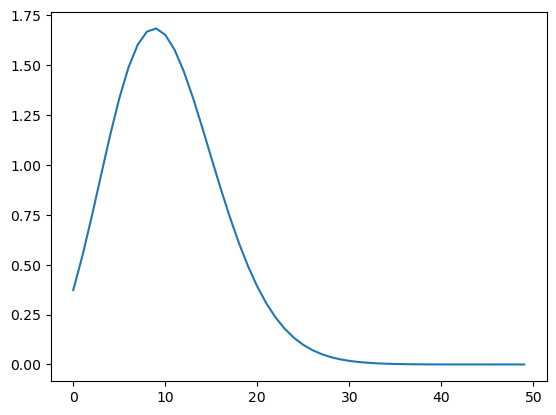

In [33]:
plt.plot(true_risk)

In [34]:
max_bound = 50
def UWE_decision(Xs):
    thresholds = np.arange(max_bound)
    # Create boolean masks for each threshold (broadcasting Xs over thresholds)
    mask1 = Xs[:, None] >= (thresholds + 1)  # For sum: x >= i+1
    mask2 = Xs[:, None] >= thresholds         # For count: x >= i
    
    # Compute sum and count for each threshold along axis 0 (over Xs)
    sum_values = np.sum(Xs[:, None] * mask1, axis=0)
    count_values = np.sum(mask2, axis=0)
    
    # Compute UWE for each threshold
    UWE = sum_values - cost * count_values
    
    # Return the threshold that maximizes UWE
    return thresholds[np.argmax(UWE)]


In [35]:
mc_samples = 500
n_range = np.arange(5,500,5)

regret = np.zeros(shape = (len(n_range),mc_samples)) # regret compared to the Bayes estimator

for i in range(len(n_range)):
    n = n_range[i]
    for j in range(mc_samples):
        mus = sample_prior(n)
        Xs = np.random.poisson(mus)
        thresh = UWE_decision(Xs)
        regret[i,j] = np.sum(mus[(Xs >= bayes_decision)]-cost) - np.sum(mus[(Xs >= thresh)]-cost)


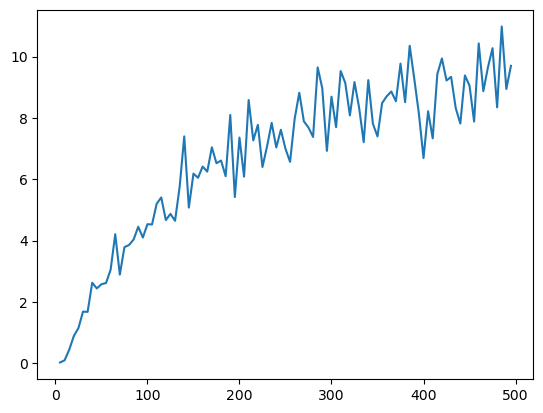

In [36]:
plt.plot(n_range, regret.mean(axis = 1)) 

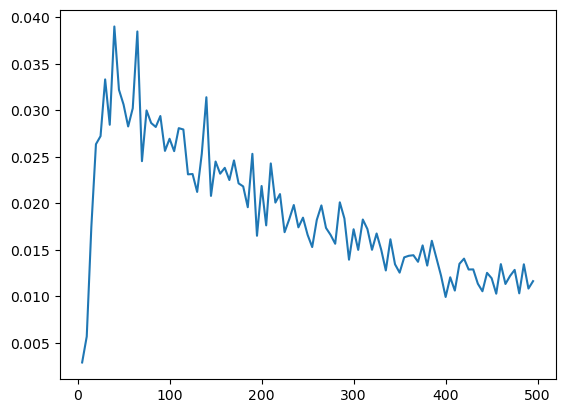

In [37]:
plt.plot(n_range, regret.mean(axis = 1)/(n_range*bayes_welfare)) # normalized to the Bayes regret

Would have expected it to be zero. Seems like in L1 it grows like sqrt(n) for small samples.

In [30]:
n = int(100)
mus = sample_prior(n)
Xs = np.random.poisson(mus)
thresh = UWE_decision(Xs)
np.sum(mus[(Xs >= bayes_decision)]-cost) - np.sum(mus[(Xs >= thresh)]-cost)

-5.472472523211081

### Some examples

Let mu = K + n^{-1/4} w.p. 1/2 and K - n^{-1/4} w.p. 1/2. What's the optimal decision? What's the posterior mean/ conditional expectation?
The optimal welfare should be positive?

What is the conditional expectation?

$ (K + n^{-0.25}) $

9
[4.54756342e-07 4.54604857e-06 2.27234276e-05 7.57245692e-05
 1.89267267e-04 3.78458850e-04 6.30659649e-04 9.00822257e-04
 1.12591524e-03 1.25093355e-03 1.25089187e-03 1.13717443e-03
 9.47676949e-04 7.29030864e-04 5.20788398e-04 3.47238547e-04
 2.17060251e-04 1.27708027e-04 7.09654504e-05 3.73601909e-05]


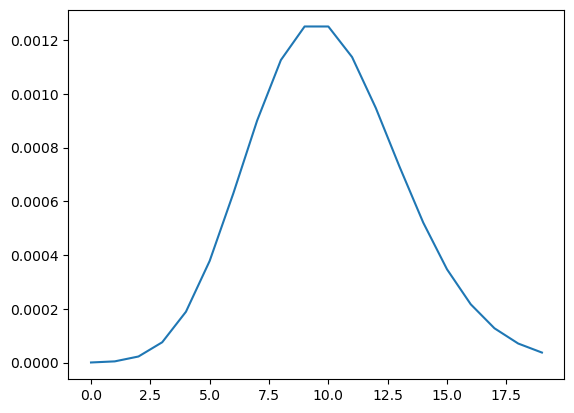

In [89]:
C_grid = np.arange(0,20)
K = 10
n = 10000
p1 = 1-scipy.stats.poisson.cdf(C_grid, K + np.power(n,-0.25))
p2 = 1-scipy.stats.poisson.cdf(C_grid, K - np.power(n,-0.25))

welfare_curve = 0.5*np.power(n,-0.25)*(p1-p2)

plt.plot(welfare_curve)
print(C_grid[np.argmax(welfare_curve)])
print(welfare_curve)

# Conjecture: minimum gap is either tiny or large? Doesn't really scale with 1/sqrt{n}?

In [76]:
print(welfare_curve[10])
print(welfare_curve[9])
print(welfare_curve[10] - welfare_curve[9])

0.003954242334161932
0.003954658787662861
-4.164535009291287e-07


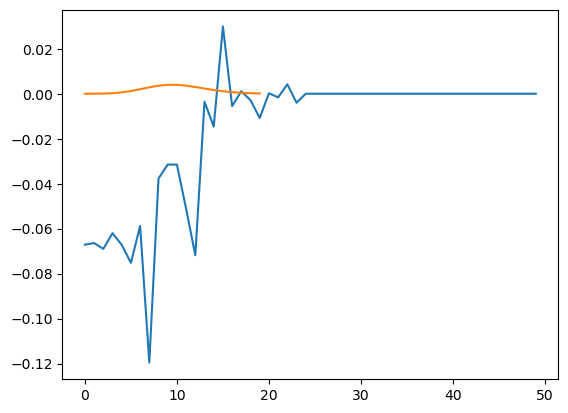

In [84]:
n = 10000
delta = np.power(n,-0.25)
mus = K - delta + np.random.randint(2, size=n)*2*delta
Xs = np.random.poisson(mus)

thresholds = np.arange(max_bound)
# Create boolean masks for each threshold (broadcasting Xs over thresholds)
mask1 = Xs[:, None] >= (thresholds + 1)  # For sum: x >= i+1
mask2 = Xs[:, None] >= thresholds         # For count: x >= i

# Compute sum and count for each threshold along axis 0 (over Xs)
sum_values = np.sum(Xs[:, None] * mask1, axis=0)
count_values = np.sum(mask2, axis=0)

# Compute UWE for each threshold
UWE = sum_values - K * count_values
plt.plot(UWE/n)
plt.plot(welfare_curve)

In [80]:
import numpy as np
from scipy.stats import poisson

def conditional_mean_mu_given_X(X, K, delta):
    """Compute E[mu | X] where mu is K+delta with prob 0.5, K-delta with prob 0.5
       and X ~ Poisson(mu)."""
    if K - delta <= 0:
        raise ValueError("K - delta must be positive for a valid Poisson rate.")

    # Compute likelihoods P(X | mu)
    P_X_given_mu1 = poisson.pmf(X, K + delta)
    P_X_given_mu2 = poisson.pmf(X, K - delta)

    # Compute posterior probabilities using Bayes' theorem
    P_mu1_given_X = P_X_given_mu1 / (P_X_given_mu1 + P_X_given_mu2)
    P_mu2_given_X = P_X_given_mu2 / (P_X_given_mu1 + P_X_given_mu2)

    # Compute conditional expectation E[mu | X]
    return P_mu1_given_X * (K + delta) + P_mu2_given_X * (K - delta)

# Example usage
K = 10
delta = 0.05
X = 1  # Observed Poisson sample
print(conditional_mean_mu_given_X(X, K, delta))


9.997751519599971
